In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /home/aditya/git/RCNN_Pneumonia
%env PROJECT_PATH /home/aditya/git/RCNN_Pneumonia

/home/aditya/git/RCNN_Pneumonia
env: PROJECT_PATH=/home/aditya/git/RCNN_Pneumonia


In [16]:
from utils.envs import *
import random
import tensorflow as tf
import pandas as pd
import numpy as np
from model.dataset import PneumoniaDataset
from mrcnn.model import log
from mrcnn import utils
from model.config import InferenceConfig
from mrcnn import visualize
from tqdm import tqdm_notebook as tqdm

In [4]:
from mrcnn import model as modellib
from utils.vis import get_ax

In [5]:
train_dataset = PneumoniaDataset(data_dir, 'train')
dev_dataset = PneumoniaDataset(data_dir, 'dev')
val_dataset = PneumoniaDataset(data_dir, 'val')
test_dataset = PneumoniaDataset(data_dir, 'test')

In [6]:
train_dataset.prepare()
dev_dataset.prepare()
val_dataset.prepare()
test_dataset.prepare()

In [7]:
DEVICE = "/cpu:0" 
TEST_MODE = "inference"

In [8]:
config = InferenceConfig()

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=logs_dir,
                              config=config)

In [10]:
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/aditya/git/RCNN_Pneumonia/logs/pneumonia20181023T0029/mask_rcnn_pneumonia_0020.h5
Re-starting from epoch 20


In [11]:
image = modellib.load_image_gt(val_dataset, config, 2)

In [12]:
image[0].shape

(512, 512, 3)

gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   90.00000  max:  353.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.400


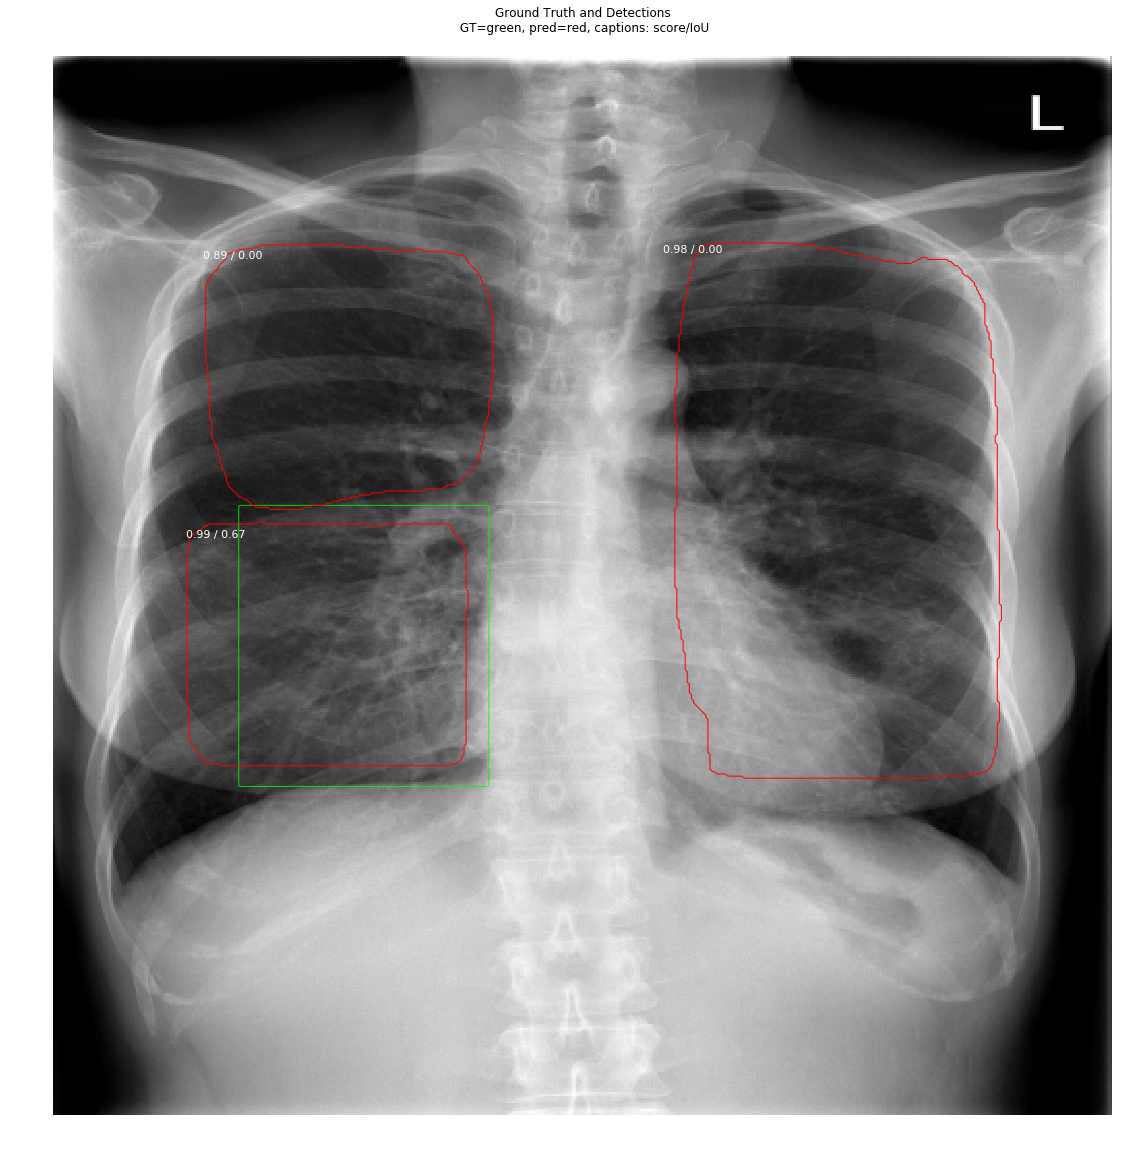

In [98]:
# Display results
r = results[0]
if not gt_class_id.shape[0] == 0. :
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
    utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                           r['rois'], r['class_ids'], r['scores'], r['masks'],
                           verbose=1)

    visualize.display_differences(
        image,
        gt_bbox, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        val_dataset.class_names, ax=get_ax(),
        show_box=False, show_mask=False,
        iou_threshold=0.5, score_threshold=0.5)


In [13]:
result = []
for idx in tqdm(test_dataset.image_ids):
    img = test_dataset.load_image(idx)
    patient_id = test_dataset.image_info[idx]['patient_id']
    prediction = model.detect([img])
    rois = prediction[0]['rois']
    score = prediction[0]['scores']
    predictionString = ''
    for i in range(len(score)):
        if score[i] > 0.95:
            x1, y1, x2, y2 = int(rois[i][1]), int(rois[i][0]), int(rois[i][3]), int(rois[i][2])
            x, y, width, height = x1, y1, x2-x1, y2-y1
            predictionString = predictionString + '{} {} {} {} {} '.format(score[i], x, y, width, height)
    result.append({
        'patientId' : patient_id,
        'predictionString' : predictionString.strip()
    })

In [14]:
result

[{'patientId': '02242633-faa0-4927-81de-b2b44940068a',
  'predictionString': '0.9884929060935974 159 470 231 257'},
 {'patientId': '2bdfab0d-4192-4a7f-a366-587c379ecdba',
  'predictionString': '0.9679692983627319 240 483 172 199 0.9539953470230103 624 438 192 282'},
 {'patientId': '19b1f7ba-bd40-4e8d-813d-da977b2306b3',
  'predictionString': '0.9911070466041565 214 502 198 203 0.9752200841903687 570 482 227 342'},
 {'patientId': '2a495fc1-09c7-4482-a2c8-71bed72628f5',
  'predictionString': '0.9680936336517334 601 512 270 207'},
 {'patientId': '2744f4b1-f0a3-4f65-be56-2b93eb72f56a',
  'predictionString': '0.9618692398071289 260 514 183 123'},
 {'patientId': '05207a0f-a1bc-46f8-8acb-aa72197e52af',
  'predictionString': '0.9800574779510498 568 479 210 267'},
 {'patientId': 'c0d8eb9f-8276-414b-8cbb-d8f28b61aac1',
  'predictionString': '0.950167715549469 565 179 130 170'},
 {'patientId': '2ef4cfe7-bbc1-4ce2-ba1e-6df54a94252c',
  'predictionString': '0.9955365657806396 279 484 266 253'},
 {'

In [17]:
result_df = pd.DataFrame(result)

In [19]:
result_df.to_csv('/home/aditya/git/RCNN_Pneumonia/output/result_0.csv', index = False)